# DATA 1030 Player Position prediction in the English Premier League

In [1]:
#import all useful packages
import pandas as pd
import matplotlib
import sklearn
from matplotlib import pylab as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score
import seaborn as sb
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
#read in the data
df=pd.read_csv('/Users/kingsley/Desktop/DATA1030/Data_1030_Project/data/EPL_data.csv')

In [3]:
#drop all the goalkeepers since goalkeepers have different stats than field players
df.drop(df[df.Position == 'Goalkeeper'].index, inplace=True)
#drop player names as well since it has nothing to do with player positions
df=df.drop(['Name'],axis=1)
#drop rows with all NaNs
df=df.dropna(axis=1,how='all')
df=df.reset_index(drop=True)
df

,Jersey Number,Club,Position,Nationality,Age,Appearances,Wins,Losses,Goals,Goals per match,...,Passes per match,Big chances created,Crosses,Cross accuracy %,Through balls,Accurate long balls,Yellow cards,Red cards,Fouls,Offsides
0,2.0,Arsenal,Defender,Spain,25.0,160,90,37,7,NaN,...,44.53,28.0,389.0,16%,31.0,144.0,23,0,125,8.0
1,3.0,Arsenal,Defender,Scotland,23.0,16,7,5,1,NaN,...,32.44,1.0,45.0,18%,0.0,22.0,2,0,9,0.0
2,4.0,Arsenal,Defender,France,19.0,0,0,0,0,NaN,...,0.00,0.0,0.0,0%,0.0,0.0,0,0,0,0.0
3,5.0,Arsenal,Defender,Greece,32.0,44,21,11,3,NaN,...,54.91,4.0,1.0,1%,2.0,172.0,18,0,56,1.0
4,16.0,Arsenal,Defender,England,25.0,41,25,9,0,NaN,...,53.66,0.0,3.0,67%,1.0,116.0,8,0,32,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,7.0,Wolverhampton-Wanderers,Forward,Portugal,20.0,31,14,7,3,0.10,...,12.87,5.0,52.0,NaN,NaN,NaN,3,0,16,5.0
498,9.0,Wolverhampton-Wanderers,Forward,Mexico,29.0,78,32,23,32,0.41,...,27.03,26.0,57.0,NaN,NaN,NaN,7,0,81,52.0
499,37.0,Wolverhampton-Wanderers,Forward,Spain,24.0,105,27,47,5,0.05,...,13.66,13.0,327.0,NaN,NaN,NaN,4,0,80,13.0
500,17.0,Wolverhampton-Wanderers,Forward,Portugal,18.0,1,0,1,0,1.00,...,1.00,0.0,0.0,NaN,NaN,NaN,0,0,0,0.0


In [4]:
df.shape

(502, 50)

In [5]:
df.dtypes

Jersey Number             float64
Club                       object
Position                   object
Nationality                object
Age                       float64
Appearances                 int64
Wins                        int64
Losses                      int64
Goals                       int64
Goals per match           float64
Headed goals              float64
Goals with right foot     float64
Goals with left foot      float64
Penalties scored          float64
Freekicks scored          float64
Shots                     float64
Shots on target           float64
Shooting accuracy %        object
Hit woodwork              float64
Big chances missed        float64
Clean sheets              float64
Goals conceded            float64
Tackles                   float64
Tackle success %           object
Last man tackles          float64
Blocked shots             float64
Interceptions             float64
Clearances                float64
Headed Clearance          float64
Clearances off

In [6]:
df.isna().sum()

Jersey Number               6
Club                        0
Position                    0
Nationality                 1
Age                         1
Appearances                 0
Wins                        0
Losses                      0
Goals                       0
Goals per match           193
Headed goals                0
Goals with right foot       0
Goals with left foot        0
Penalties scored          193
Freekicks scored          193
Shots                     193
Shots on target           193
Shooting accuracy %       193
Hit woodwork                0
Big chances missed        193
Clean sheets              309
Goals conceded            309
Tackles                     0
Tackle success %          112
Last man tackles          309
Blocked shots               0
Interceptions               0
Clearances                  0
Headed Clearance            0
Clearances off line       309
Recoveries                112
Duels won                 112
Duels lost                112
Successful

In [7]:
#change percentages to floats
pd.set_option("display.max_columns", 100)
df['Shooting accuracy %'] = df['Shooting accuracy %'].str.rstrip('%').astype('float') / 100.0
df['Tackle success %'] = df['Tackle success %'].str.rstrip('%').astype('float') / 100.0
df['Cross accuracy %'] = df['Cross accuracy %'].str.rstrip('%').astype('float') / 100.0
df

,Jersey Number,Club,Position,Nationality,Age,Appearances,Wins,Losses,Goals,Goals per match,Headed goals,Goals with right foot,Goals with left foot,Penalties scored,Freekicks scored,Shots,Shots on target,Shooting accuracy %,Hit woodwork,Big chances missed,Clean sheets,Goals conceded,Tackles,Tackle success %,Last man tackles,Blocked shots,Interceptions,Clearances,Headed Clearance,Clearances off line,Recoveries,Duels won,Duels lost,Successful 50/50s,Aerial battles won,Aerial battles lost,Own goals,Errors leading to goal,Assists,Passes,Passes per match,Big chances created,Crosses,Cross accuracy %,Through balls,Accurate long balls,Yellow cards,Red cards,Fouls,Offsides
0,2.0,Arsenal,Defender,Spain,25.0,160,90,37,7,NaN,0.0,4.0,3.0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,53.0,166.0,214.0,0.78,1.0,32.0,208.0,304.0,143.0,3.0,732.0,611.0,709.0,196.0,161.0,215.0,1.0,1.0,18,7125,44.53,28.0,389.0,0.16,31.0,144.0,23,0,125,8.0
1,3.0,Arsenal,Defender,Scotland,23.0,16,7,5,1,NaN,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,2.0,16.0,21.0,0.81,0.0,1.0,12.0,32.0,12.0,0.0,63.0,55.0,38.0,12.0,10.0,16.0,0.0,0.0,1,519,32.44,1.0,45.0,0.18,0.0,22.0,2,0,9,0.0
2,4.0,Arsenal,Defender,France,19.0,0,0,0,0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.00,0.0,0.0,0.00,0.0,0.0,0,0,0,0.0
3,5.0,Arsenal,Defender,Greece,32.0,44,21,11,3,NaN,1.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,9.0,58.0,67.0,0.61,1.0,4.0,43.0,175.0,82.0,1.0,173.0,227.0,160.0,11.0,115.0,73.0,0.0,1.0,2,2416,54.91,4.0,1.0,0.01,2.0,172.0,18,0,56,1.0
4,16.0,Arsenal,Defender,England,25.0,41,25,9,0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,10.0,45.0,50.0,0.70,1.0,3.0,54.0,170.0,92.0,0.0,192.0,176.0,142.0,19.0,96.0,64.0,0.0,0.0,0,2200,53.66,0.0,3.0,0.67,1.0,116.0,8,0,32,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,7.0,Wolverhampton-Wanderers,Forward,Portugal,20.0,31,14,7,3,0.10,0.0,1.0,2.0,0.0,0.0,19.0,6.0,0.32,0.0,3.0,NaN,NaN,11.0,NaN,NaN,7.0,9.0,3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,399,12.87,5.0,52.0,NaN,NaN,NaN,3,0,16,5.0
498,9.0,Wolverhampton-Wanderers,Forward,Mexico,29.0,78,32,23,32,0.41,9.0,19.0,4.0,6.0,0.0,237.0,82.0,0.35,7.0,20.0,NaN,NaN,51.0,NaN,NaN,53.0,43.0,75.0,57.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,2108,27.03,26.0,57.0,NaN,NaN,NaN,7,0,81,52.0
499,37.0,Wolverhampton-Wanderers,Forward,Spain,24.0,105,27,47,5,0.05,0.0,5.0,0.0,0.0,0.0,78.0,21.0,0.27,2.0,6.0,NaN,NaN,86.0,NaN,NaN,26.0,27.0,26.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,1434,13.66,13.0,327.0,NaN,NaN,NaN,4,0,80,13.0
500,17.0,Wolverhampton-Wanderers,Forward,Portugal,18.0,1,0,1,0,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1.00,0.0,0.0,NaN,NaN,NaN,0,0,0,0.0


In [8]:
#There is a known error in the goals per match column, fixed it by reclaculating
goals_per_mat=[]
for i in range(df.shape[0]):
    goals_per_mat.append(df['Goals'][i]/df['Appearances'][i] if df['Appearances'][i]!=0 else 0)
df['Goals per match']=goals_per_mat
df

,Jersey Number,Club,Position,Nationality,Age,Appearances,Wins,Losses,Goals,Goals per match,Headed goals,Goals with right foot,Goals with left foot,Penalties scored,Freekicks scored,Shots,Shots on target,Shooting accuracy %,Hit woodwork,Big chances missed,Clean sheets,Goals conceded,Tackles,Tackle success %,Last man tackles,Blocked shots,Interceptions,Clearances,Headed Clearance,Clearances off line,Recoveries,Duels won,Duels lost,Successful 50/50s,Aerial battles won,Aerial battles lost,Own goals,Errors leading to goal,Assists,Passes,Passes per match,Big chances created,Crosses,Cross accuracy %,Through balls,Accurate long balls,Yellow cards,Red cards,Fouls,Offsides
0,2.0,Arsenal,Defender,Spain,25.0,160,90,37,7,0.043750,0.0,4.0,3.0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,53.0,166.0,214.0,0.78,1.0,32.0,208.0,304.0,143.0,3.0,732.0,611.0,709.0,196.0,161.0,215.0,1.0,1.0,18,7125,44.53,28.0,389.0,0.16,31.0,144.0,23,0,125,8.0
1,3.0,Arsenal,Defender,Scotland,23.0,16,7,5,1,0.062500,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,2.0,16.0,21.0,0.81,0.0,1.0,12.0,32.0,12.0,0.0,63.0,55.0,38.0,12.0,10.0,16.0,0.0,0.0,1,519,32.44,1.0,45.0,0.18,0.0,22.0,2,0,9,0.0
2,4.0,Arsenal,Defender,France,19.0,0,0,0,0,0.000000,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.00,0.0,0.0,0.00,0.0,0.0,0,0,0,0.0
3,5.0,Arsenal,Defender,Greece,32.0,44,21,11,3,0.068182,1.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,9.0,58.0,67.0,0.61,1.0,4.0,43.0,175.0,82.0,1.0,173.0,227.0,160.0,11.0,115.0,73.0,0.0,1.0,2,2416,54.91,4.0,1.0,0.01,2.0,172.0,18,0,56,1.0
4,16.0,Arsenal,Defender,England,25.0,41,25,9,0,0.000000,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,10.0,45.0,50.0,0.70,1.0,3.0,54.0,170.0,92.0,0.0,192.0,176.0,142.0,19.0,96.0,64.0,0.0,0.0,0,2200,53.66,0.0,3.0,0.67,1.0,116.0,8,0,32,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,7.0,Wolverhampton-Wanderers,Forward,Portugal,20.0,31,14,7,3,0.096774,0.0,1.0,2.0,0.0,0.0,19.0,6.0,0.32,0.0,3.0,NaN,NaN,11.0,NaN,NaN,7.0,9.0,3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,399,12.87,5.0,52.0,NaN,NaN,NaN,3,0,16,5.0
498,9.0,Wolverhampton-Wanderers,Forward,Mexico,29.0,78,32,23,32,0.410256,9.0,19.0,4.0,6.0,0.0,237.0,82.0,0.35,7.0,20.0,NaN,NaN,51.0,NaN,NaN,53.0,43.0,75.0,57.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,2108,27.03,26.0,57.0,NaN,NaN,NaN,7,0,81,52.0
499,37.0,Wolverhampton-Wanderers,Forward,Spain,24.0,105,27,47,5,0.047619,0.0,5.0,0.0,0.0,0.0,78.0,21.0,0.27,2.0,6.0,NaN,NaN,86.0,NaN,NaN,26.0,27.0,26.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,1434,13.66,13.0,327.0,NaN,NaN,NaN,4,0,80,13.0
500,17.0,Wolverhampton-Wanderers,Forward,Portugal,18.0,1,0,1,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1.00,0.0,0.0,NaN,NaN,NaN,0,0,0,0.0


In [9]:
#deal with missing values
df['Nationality']=df['Nationality'].fillna('None')
df['Age']=df['Age'].fillna(df['Age'].mean())


In [10]:
#fill missing stats
df=df.fillna(0)

In [11]:
def modify_class(x):
    if x=='Forward':
        return 0
    elif x=='Defender':
        return 2
    else:
        return 1
#change target variable classes to 0,1,2
df['Position']=df['Position'].apply(lambda x: modify_class(x))

In [12]:
df

,Jersey Number,Club,Position,Nationality,Age,Appearances,Wins,Losses,Goals,Goals per match,Headed goals,Goals with right foot,Goals with left foot,Penalties scored,Freekicks scored,Shots,Shots on target,Shooting accuracy %,Hit woodwork,Big chances missed,Clean sheets,Goals conceded,Tackles,Tackle success %,Last man tackles,Blocked shots,Interceptions,Clearances,Headed Clearance,Clearances off line,Recoveries,Duels won,Duels lost,Successful 50/50s,Aerial battles won,Aerial battles lost,Own goals,Errors leading to goal,Assists,Passes,Passes per match,Big chances created,Crosses,Cross accuracy %,Through balls,Accurate long balls,Yellow cards,Red cards,Fouls,Offsides
0,2.0,Arsenal,2,Spain,25.0,160,90,37,7,0.043750,0.0,4.0,3.0,0.0,0.0,0.0,0.0,0.00,3.0,0.0,53.0,166.0,214.0,0.78,1.0,32.0,208.0,304.0,143.0,3.0,732.0,611.0,709.0,196.0,161.0,215.0,1.0,1.0,18,7125,44.53,28.0,389.0,0.16,31.0,144.0,23,0,125,8.0
1,3.0,Arsenal,2,Scotland,23.0,16,7,5,1,0.062500,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,2.0,16.0,21.0,0.81,0.0,1.0,12.0,32.0,12.0,0.0,63.0,55.0,38.0,12.0,10.0,16.0,0.0,0.0,1,519,32.44,1.0,45.0,0.18,0.0,22.0,2,0,9,0.0
2,4.0,Arsenal,2,France,19.0,0,0,0,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.00,0.0,0.0,0.00,0.0,0.0,0,0,0,0.0
3,5.0,Arsenal,2,Greece,32.0,44,21,11,3,0.068182,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,0.0,9.0,58.0,67.0,0.61,1.0,4.0,43.0,175.0,82.0,1.0,173.0,227.0,160.0,11.0,115.0,73.0,0.0,1.0,2,2416,54.91,4.0,1.0,0.01,2.0,172.0,18,0,56,1.0
4,16.0,Arsenal,2,England,25.0,41,25,9,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,10.0,45.0,50.0,0.70,1.0,3.0,54.0,170.0,92.0,0.0,192.0,176.0,142.0,19.0,96.0,64.0,0.0,0.0,0,2200,53.66,0.0,3.0,0.67,1.0,116.0,8,0,32,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,7.0,Wolverhampton-Wanderers,0,Portugal,20.0,31,14,7,3,0.096774,0.0,1.0,2.0,0.0,0.0,19.0,6.0,0.32,0.0,3.0,0.0,0.0,11.0,0.00,0.0,7.0,9.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,399,12.87,5.0,52.0,0.00,0.0,0.0,3,0,16,5.0
498,9.0,Wolverhampton-Wanderers,0,Mexico,29.0,78,32,23,32,0.410256,9.0,19.0,4.0,6.0,0.0,237.0,82.0,0.35,7.0,20.0,0.0,0.0,51.0,0.00,0.0,53.0,43.0,75.0,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13,2108,27.03,26.0,57.0,0.00,0.0,0.0,7,0,81,52.0
499,37.0,Wolverhampton-Wanderers,0,Spain,24.0,105,27,47,5,0.047619,0.0,5.0,0.0,0.0,0.0,78.0,21.0,0.27,2.0,6.0,0.0,0.0,86.0,0.00,0.0,26.0,27.0,26.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12,1434,13.66,13.0,327.0,0.00,0.0,0.0,4,0,80,13.0
500,17.0,Wolverhampton-Wanderers,0,Portugal,18.0,1,0,1,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1.00,0.0,0.0,0.00,0.0,0.0,0,0,0,0.0


In [13]:
#divide target variable and features
X=df.loc[:, df.columns != 'Position']
y=df['Position']

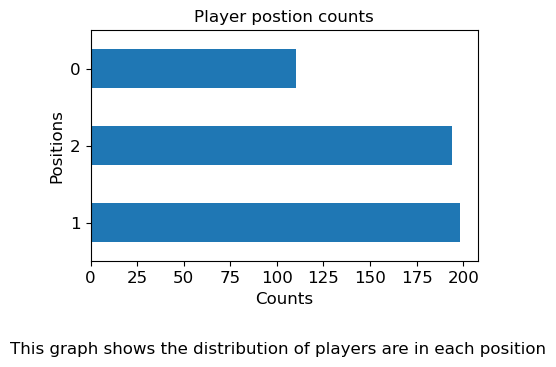

In [14]:
#plot the target variable
plt.rcParams['figure.figsize'] = [5,3]

pd.value_counts(y).plot.barh()
plt.xticks(size=12)
plt.yticks(size=12)
plt.ylabel('Positions',size=12)
plt.xlabel('Counts',size=12)
plt.title('Player postion counts',size=12)
txt="This graph shows the distribution of players are in each position"
plt.figtext(0.5, -0.2, txt, ha='center',size=12)
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
plt.savefig('/Users/kingsley/Desktop/DATA1030/Data_1030_Project/figures/player_position_coounts_report.png', format='png', bbox_inches="tight", dpi=300)
plt.show()

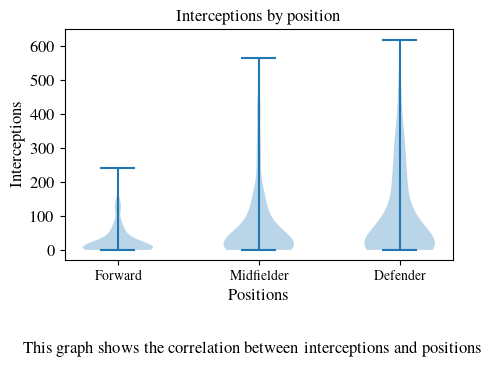

In [15]:
#plot Interceptions vs target 
dataset = [df[df['Position']==0]['Interceptions'].values,
           df[df['Position']==1]['Interceptions'].values,
            df[df['Position']==2]['Interceptions'].values]

plt.violinplot(dataset = dataset)
plt.xticks([1,2,3],['Forward','Midfielder','Defender'],size=10)
plt.ylabel('Interceptions',size=12)
plt.yticks(size=12)
plt.xlabel('Positions',size=12)
plt.title('Interceptions by position',size=12)

rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
txt="This graph shows the correlation between interceptions and positions"
plt.figtext(0.5, -0.2, txt, ha='center',size=12)

plt.savefig('/Users/kingsley/Desktop/DATA1030/Data_1030_Project/figures/interception_position_report.png', format='png', bbox_inches="tight", dpi=300)

plt.show()

<Figure size 500x300 with 0 Axes>

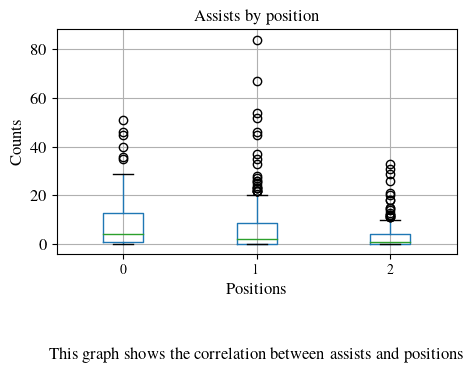

In [16]:
#plot assist vs target
plt.figure(figsize=(5,3))

df[['Assists','Position']].boxplot(by='Position')
plt.ylabel('Counts',size=12)
plt.xlabel('Positions',size=12)
plt.xticks(size=10)
plt.yticks(size=12)
plt.title('Assists by position',size=12)
plt.suptitle('')
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
txt="This graph shows the correlation between assists and positions"
plt.figtext(0.5, -0.2, txt, ha='center',size=12)

plt.savefig('/Users/kingsley/Desktop/DATA1030/Data_1030_Project/figures/assists_position_report.png', format='png', bbox_inches="tight", dpi=300)

plt.show()

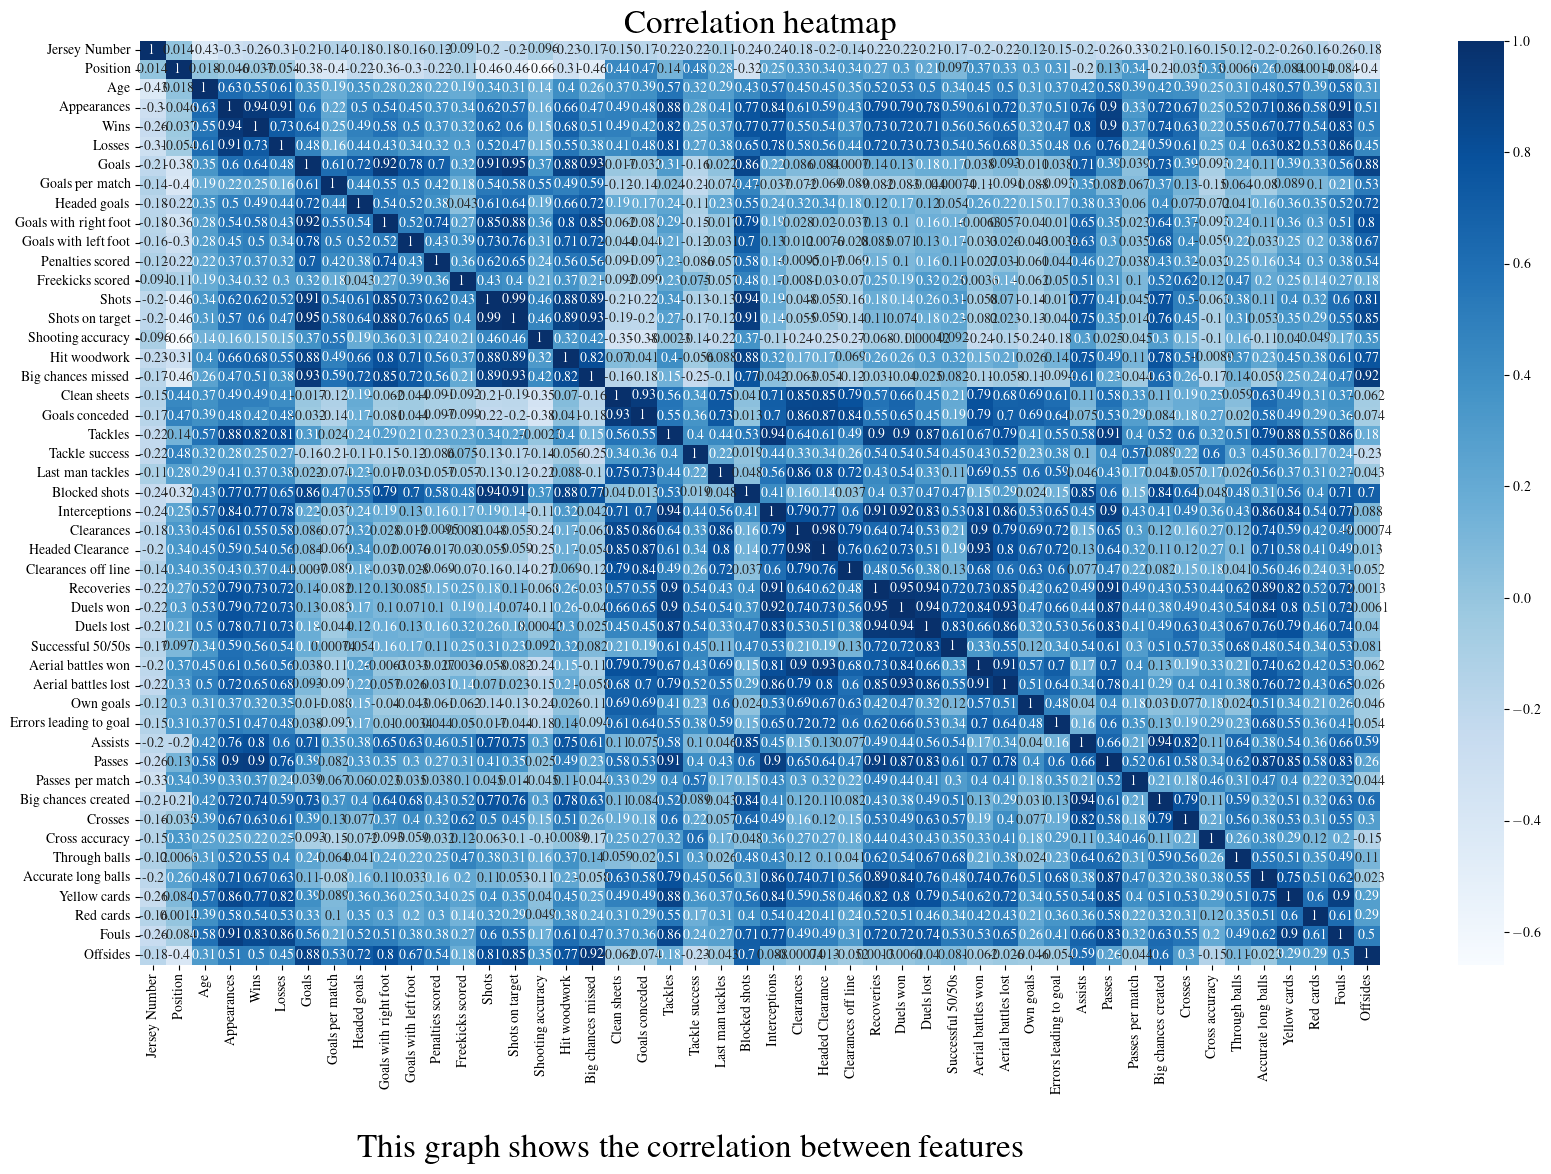

In [17]:
#get heatmap
plt.rcParams['figure.figsize'] = [20,12]

corr = df.corr()
sb.heatmap(corr, cmap="Blues", annot=True)
plt.title('Correlation heatmap',size=24)
plt.suptitle('')
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
txt="This graph shows the correlation between features"
plt.figtext(0.4, -0.05, txt, ha='center',size=24)
plt.savefig('/Users/kingsley/Desktop/DATA1030/Data_1030_Project/figures/heatmap.png', format='png', bbox_inches="tight", dpi=300)


In [18]:
#collect feature names with different preprocess methods
onehot_ftrs = ['Jersey Number', 'Club', 'Nationality']
minmax_ftrs = ['Age']
std_ftrs = ['Appearances',
       'Wins', 'Losses', 'Goals', 'Goals per match', 'Headed goals',
       'Goals with right foot', 'Goals with left foot', 'Penalties scored',
       'Freekicks scored', 'Shots', 'Shots on target','Shooting accuracy %',
       'Hit woodwork', 'Big chances missed', 'Clean sheets', 'Goals conceded',
       'Tackles', 'Tackle success %', 'Last man tackles', 'Blocked shots',
       'Interceptions', 'Clearances', 'Headed Clearance',
       'Clearances off line', 'Recoveries', 'Duels won', 'Duels lost',
       'Successful 50/50s', 'Aerial battles won', 'Aerial battles lost',
       'Own goals', 'Errors leading to goal', 'Assists', 'Passes',
       'Passes per match', 'Big chances created', 'Crosses',
       'Cross accuracy %', 'Through balls', 'Accurate long balls',
       'Yellow cards', 'Red cards', 'Fouls', 'Offsides']

# collect all the encoders
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'), onehot_ftrs),
        ('minmax', MinMaxScaler(), minmax_ftrs),
        ('std', StandardScaler(), std_ftrs)])




In [19]:
#make the pipeline
def MLpipe_KFold_Accuracy(X,y,preprocessor,algo,param_grid):
    nr_states = 5
    test_scores = np.zeros(nr_states)
    final_models = []
    X_tests=[]
    y_tests=[]
    for i in range(nr_states):
        print(i)
        #split data
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state=42*i)
        X_tests.append(X_test)   
        y_tests.append(y_test)
        kf = KFold(n_splits=3,shuffle=True,random_state=42*i)
        clf = algo 

        pipe = make_pipeline(preprocessor,clf)

        grid = GridSearchCV(pipe, param_grid=param_grid,scoring = 'accuracy',
                            cv=kf, return_train_score = True, n_jobs=-1, verbose=True)

        grid.fit(X_train, y_train)
        results = pd.DataFrame(grid.cv_results_)

        print('best model parameters:',grid.best_params_)
        print('validation score:',grid.best_score_) 
        # save the model
        final_models.append(grid)
        # calculate and save the test score
        y_test_pred = final_models[-1].predict(X_test)
        test_scores[i] = accuracy_score(y_test,y_test_pred)
        print('test score:',test_scores[i])
    feature_names = grid.best_estimator_[0].get_feature_names_out()
    return final_models, test_scores, X_tests, y_tests, np.array(feature_names)



In [20]:
#train random forest
param_grid = {
              'randomforestclassifier__max_depth': [1, 3, 10, 30, 100,300,500], 
                'randomforestclassifier__n_estimators': [1,3,10,30,100,300,500]
              } 
randomforest_final_models, randomforest_test_scores, randomforest_X_test, randomforest_y_test, feature_names=MLpipe_KFold_Accuracy(X,y,preprocessor,RandomForestClassifier(random_state=42),param_grid)
print('mean is ',np.mean(randomforest_test_scores))
print('std is ',np.std(randomforest_test_scores))

0
Fitting 3 folds for each of 49 candidates, totalling 147 fits
best model parameters: {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__n_estimators': 30}
validation score: 0.9002730707365428
test score: 0.8910891089108911
1
Fitting 3 folds for each of 49 candidates, totalling 147 fits
best model parameters: {'randomforestclassifier__max_depth': 3, 'randomforestclassifier__n_estimators': 30}
validation score: 0.9026671155500692
test score: 0.8811881188118812
2
Fitting 3 folds for each of 49 candidates, totalling 147 fits
best model parameters: {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__n_estimators': 300}
validation score: 0.905266898589758
test score: 0.8514851485148515
3
Fitting 3 folds for each of 49 candidates, totalling 147 fits
best model parameters: {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__n_estimators': 100}
validation score: 0.8727976658063068
test score: 0.9306930693069307
4
Fitting 3 folds for each of 49 can

In [21]:
#collect the top 10 most important feature
randomforest_final_models[-1].best_estimator_[1].feature_importances_
df_feature_importance=pd.DataFrame({'name':feature_names,'importance':randomforest_final_models[-1].best_estimator_[1].feature_importances_})
df_feature_importance=df_feature_importance.sort_values('importance')
df_feature_importance=df_feature_importance.iloc[-10:].set_index(['name'])

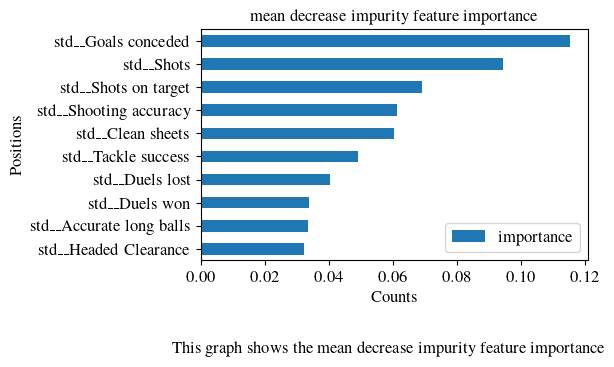

In [22]:
#plot the top 10 most important feature
plt.rcParams['figure.figsize'] = [5,3]
plt.rcParams.update({'font.size': 12})

df_feature_importance.plot.barh()
plt.xticks(size=12)
plt.yticks(size=12)
plt.ylabel('Positions',size=12)
plt.xlabel('Counts',size=12)
plt.title('mean decrease impurity feature importance',size=12)
txt="This graph shows the mean decrease impurity feature importance"
plt.figtext(0.5, -0.2, txt, ha='center',size=12)
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
plt.savefig('/Users/kingsley/Desktop/DATA1030/Data_1030_Project/figures/rf_test_score.png', format='png', bbox_inches="tight", dpi=300)
plt.show()

In [ ]:
#copmute permutation importance
import warnings
warnings.filterwarnings("ignore")

nr_runs = 10
scores = np.zeros([len(feature_names),nr_runs])
X_test=randomforest_final_models[-1].best_estimator_[0].transform(randomforest_X_test[-1])
model=randomforest_final_models[-1].best_estimator_[1]
X_test_prep=pd.DataFrame(data=X_test,columns=randomforest_final_models[-1].best_estimator_[0].get_feature_names_out())
test_score = accuracy_score(randomforest_y_test[-1],model.predict(X_test_prep))
print('test score = ',test_score)

# loop through the features
for i in range(len(feature_names)):
    print('shuffling '+str(feature_names[i]))
    acc_scores = []
    for j in range(nr_runs):
        X_test_shuffled = X_test_prep.copy()
        X_test_shuffled[feature_names[i]] = np.random.permutation(X_test_prep[feature_names[i]].values)
        acc_scores.append(accuracy_score(randomforest_y_test[-1],model.predict(X_test_shuffled)))
    print('   shuffled test score:',np.around(np.mean(acc_scores),3),'+/-',np.around(np.std(acc_scores),3))
    scores[i] = acc_scores

In [23]:
import shap
shap.initjs() # required for visualizations later on
# create the explainer object with the random forest model
explainer = shap.TreeExplainer(randomforest_final_models[-1].best_estimator_[1])
# transform the test set
X_test_transformed = randomforest_final_models[-1].best_estimator_[0].transform(randomforest_X_test[-1])
print(np.shape(X_test_transformed))
# calculate shap values on the first 1000 points in the test
shap_values = explainer.shap_values(X_test_transformed[:1000])
print(np.shape(shap_values))

(101, 179)
(3, 101, 179)


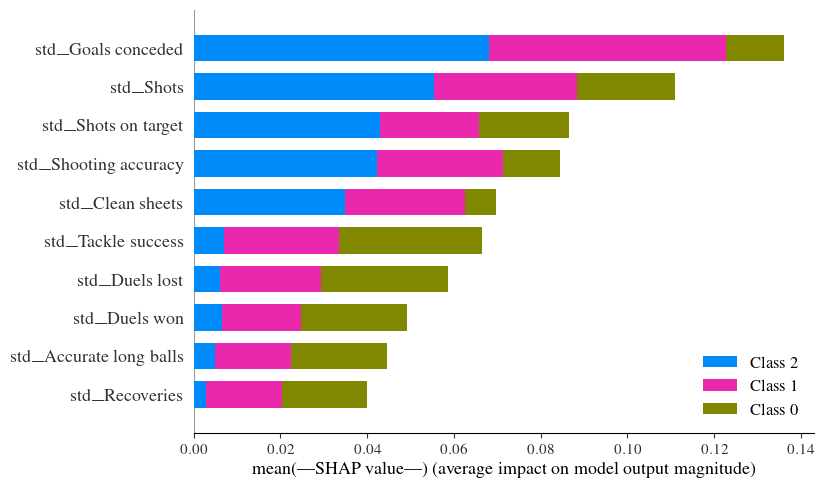

In [24]:
#plot shap global feature importance
shap.summary_plot(shap_values, X_test_transformed[:1000],feature_names = feature_names,max_display=10,show=False)
plt.savefig('/Users/kingsley/Desktop/DATA1030/Data_1030_Project/figures/shap_test_score.png', format='png', bbox_inches="tight", dpi=300)


In [25]:
shap_values=np.round(shap_values,3)
shap_values[0][4]
X_test_transformed=np.round(X_test_transformed,3)

In [26]:
index = 4# the index of the point to explain
plt.rcParams.update({'font.size': 30})

print(explainer.expected_value[0]) # we explain class 0 predictions
shap.force_plot(explainer.expected_value[0], shap_values[0][index], features = X_test_transformed[index,:],feature_names = feature_names,show=False,matplotlib=True)
plt.savefig('/Users/kingsley/Desktop/DATA1030/Data_1030_Project/figures/shap_local_0.png', format='png', bbox_inches="tight", dpi=300)


0.2116708229426434


In [27]:
index = 4 # the index of the point to explain
print(explainer.expected_value[1]) # we explain class 0 predictions
shap.force_plot(explainer.expected_value[1], shap_values[1][index,:], features = X_test_transformed[index,:],feature_names = feature_names,show=False,matplotlib=True)
plt.savefig('/Users/kingsley/Desktop/DATA1030/Data_1030_Project/figures/shap_local_1.png', format='png', bbox_inches="tight", dpi=300)


0.38962593516209487


In [28]:
index = 4 # the index of the point to explain
print(explainer.expected_value[2]) # we explain class 0 predictions
shap.force_plot(explainer.expected_value[2], shap_values[2][index,:], features = X_test_transformed[index,:],feature_names = feature_names,show=False,matplotlib=True)
plt.savefig('/Users/kingsley/Desktop/DATA1030/Data_1030_Project/figures/shap_local_2.png', format='png', bbox_inches="tight", dpi=300)


0.3987032418952618


In [29]:
#train KNN
from sklearn.neighbors import KNeighborsClassifier
param_grid = {
                'kneighborsclassifier__n_neighbors': [1,3,10,30,50],
                'kneighborsclassifier__leaf_size':[1,3,10,30,50],
                'kneighborsclassifier__p':[1,2]
                  } 

kneighborsclassifier_final_models, kneighborsclassifier_test_scores, kneighborsclassifier_X_test, kneighborsclassifier_y_test, feature_names=MLpipe_KFold_Accuracy(X,y,preprocessor,KNeighborsClassifier(),param_grid)
print('mean is ',np.mean(kneighborsclassifier_test_scores))
print('std is ',np.std(kneighborsclassifier_test_scores))

0
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/kingsley/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/kingsley/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated,

/Users/kingsley/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/kingsley/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated,

/Users/kingsley/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/kingsley/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated,

/Users/kingsley/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/kingsley/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated,

/Users/kingsley/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/kingsley/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated,

best model parameters: {'kneighborsclassifier__leaf_size': 1, 'kneighborsclassifier__n_neighbors': 30, 'kneighborsclassifier__p': 1}
validation score: 0.835428122545169
test score: 0.8514851485148515
1
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/kingsley/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/kingsley/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated,

/Users/kingsley/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/kingsley/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated,

/Users/kingsley/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/kingsley/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated,

/Users/kingsley/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/kingsley/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated,

best model parameters: {'kneighborsclassifier__leaf_size': 1, 'kneighborsclassifier__n_neighbors': 10, 'kneighborsclassifier__p': 2}
validation score: 0.8353346051696405
test score: 0.8613861386138614
2
Fitting 3 folds for each of 50 candidates, totalling 150 fits


 and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/kingsley/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/kingsley/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciP

/Users/kingsley/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/kingsley/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated,

/Users/kingsley/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/kingsley/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated,

/Users/kingsley/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/kingsley/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated,

best model parameters: {'kneighborsclassifier__leaf_size': 1, 'kneighborsclassifier__n_neighbors': 30, 'kneighborsclassifier__p': 1}
validation score: 0.8628474170500878
test score: 0.8316831683168316
3
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/kingsley/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/kingsley/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated,

/Users/kingsley/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/kingsley/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated,

/Users/kingsley/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/kingsley/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated,

/Users/kingsley/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/kingsley/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated,

best model parameters: {'kneighborsclassifier__leaf_size': 1, 'kneighborsclassifier__n_neighbors': 10, 'kneighborsclassifier__p': 1}
validation score: 0.8178842628960461
test score: 0.8712871287128713
4
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/kingsley/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/kingsley/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated,

/Users/kingsley/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/kingsley/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated,

/Users/kingsley/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/kingsley/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated,

best model parameters: {'kneighborsclassifier__leaf_size': 1, 'kneighborsclassifier__n_neighbors': 10, 'kneighborsclassifier__p': 2}
validation score: 0.8129652489432537
test score: 0.8613861386138614
mean is  0.8554455445544555
std is  0.013430356402228266


  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/kingsley/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/kingsley/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over

In [30]:
#train SVC
from sklearn.svm import SVC

param_grid = {
              'svc__gamma': [1,0.1,0.01,0.001],
                'svc__C': [0.1, 1, 10, 100, 1000],
                'svc__degree':[0, 1, 2, 3, 4, 5, 6],'svc__kernel': ['rbf', 'poly', 'sigmoid']
              } 

svc_final_models, svc_test_scores, svc_X_test, svc_y_test, feature_names=MLpipe_KFold_Accuracy(X,y,preprocessor,SVC(),param_grid)
print('mean is ',np.mean(svc_test_scores))
print('std is ',np.std(svc_test_scores))


0
Fitting 3 folds for each of 420 candidates, totalling 1260 fits
best model parameters: {'svc__C': 10, 'svc__degree': 0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}
validation score: 0.8428908091123329
test score: 0.8514851485148515
1
Fitting 3 folds for each of 420 candidates, totalling 1260 fits
best model parameters: {'svc__C': 10, 'svc__degree': 0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}
validation score: 0.8402723225975386
test score: 0.8712871287128713
2
Fitting 3 folds for each of 420 candidates, totalling 1260 fits
best model parameters: {'svc__C': 100, 'svc__degree': 0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}
validation score: 0.8579471065724013
test score: 0.8316831683168316
3
Fitting 3 folds for each of 420 candidates, totalling 1260 fits
best model parameters: {'svc__C': 10, 'svc__degree': 0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}
validation score: 0.8328283395054802
test score: 0.8811881188118812
4
Fitting 3 folds for each of 420 candidates, totalling 1260 fits
be

In [31]:
#train logistic regression
from sklearn.linear_model import LogisticRegression

param_grid = {
              'logisticregression__C': [100, 10, 1.0, 0.1, 0.01],
                'logisticregression__penalty':['l1','l2','elasticnet']
              } 

logisticregression_final_models, logisticregression_test_scores, logisticregression_X_test, logisticregression_y_test, feature_names=MLpipe_KFold_Accuracy(X,y,preprocessor,LogisticRegression(max_iter=100000,solver='saga'),param_grid)
print('mean is ',np.mean(logisticregression_test_scores))
print('std is ',np.std(logisticregression_test_scores))


0
Fitting 3 folds for each of 15 candidates, totalling 45 fits



15 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/kingsley/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/kingsley/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/kingsley/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1101, in fit
    raise ValueError(
ValueError: l1_ratio must be between 0 and 1; g

best model parameters: {'logisticregression__C': 0.1, 'logisticregression__penalty': 'l1'}
validation score: 0.8528597613436576
test score: 0.8613861386138614
1
Fitting 3 folds for each of 15 candidates, totalling 45 fits



15 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/kingsley/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/kingsley/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/kingsley/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1101, in fit
    raise ValueError(
ValueError: l1_ratio must be between 0 and 1; g

best model parameters: {'logisticregression__C': 0.1, 'logisticregression__penalty': 'l2'}
validation score: 0.8552351026820784
test score: 0.8613861386138614
2
Fitting 3 folds for each of 15 candidates, totalling 45 fits



15 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/kingsley/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/kingsley/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/kingsley/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1101, in fit
    raise ValueError(
ValueError: l1_ratio must be between 0 and 1; g

best model parameters: {'logisticregression__C': 0.1, 'logisticregression__penalty': 'l2'}
validation score: 0.8728724797067295
test score: 0.8316831683168316
3
Fitting 3 folds for each of 15 candidates, totalling 45 fits



15 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/kingsley/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/kingsley/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/kingsley/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1101, in fit
    raise ValueError(
ValueError: l1_ratio must be between 0 and 1; g

best model parameters: {'logisticregression__C': 0.1, 'logisticregression__penalty': 'l2'}
validation score: 0.8552351026820784
test score: 0.8910891089108911
4
Fitting 3 folds for each of 15 candidates, totalling 45 fits



15 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/kingsley/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/kingsley/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/kingsley/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1101, in fit
    raise ValueError(
ValueError: l1_ratio must be between 0 and 1; g

best model parameters: {'logisticregression__C': 0.1, 'logisticregression__penalty': 'l1'}
validation score: 0.8527475404930236
test score: 0.8613861386138614
mean is  0.8613861386138615
std is  0.018785807882188407


In [32]:
#copmute permutation importance
import warnings
warnings.filterwarnings("ignore")

nr_runs = 10
scores = np.zeros([len(feature_names),nr_runs])
X_test=randomforest_final_models[-1].best_estimator_[0].transform(randomforest_X_test[-1])
model=randomforest_final_models[-1].best_estimator_[1]
X_test_prep=pd.DataFrame(data=X_test,columns=randomforest_final_models[-1].best_estimator_[0].get_feature_names_out())
test_score = accuracy_score(randomforest_y_test[-1],model.predict(X_test_prep))
print('test score = ',test_score)

# loop through the features
for i in range(len(feature_names)):
    print('shuffling '+str(feature_names[i]))
    acc_scores = []
    for j in range(nr_runs):
        X_test_shuffled = X_test_prep.copy()
        X_test_shuffled[feature_names[i]] = np.random.permutation(X_test_prep[feature_names[i]].values)
        acc_scores.append(accuracy_score(randomforest_y_test[-1],model.predict(X_test_shuffled)))
    print('   shuffled test score:',np.around(np.mean(acc_scores),3),'+/-',np.around(np.std(acc_scores),3))
    scores[i] = acc_scores

test score =  0.8613861386138614
shuffling onehot__Jersey Number_0.0
   shuffled test score: 0.86 +/- 0.003
shuffling onehot__Jersey Number_2.0
   shuffled test score: 0.861 +/- 0.0
shuffling onehot__Jersey Number_3.0
   shuffled test score: 0.861 +/- 0.0
shuffling onehot__Jersey Number_4.0
   shuffled test score: 0.86 +/- 0.003
shuffling onehot__Jersey Number_5.0
   shuffled test score: 0.861 +/- 0.0
shuffling onehot__Jersey Number_6.0
   shuffled test score: 0.861 +/- 0.0
shuffling onehot__Jersey Number_7.0
   shuffled test score: 0.863 +/- 0.004
shuffling onehot__Jersey Number_8.0
   shuffled test score: 0.861 +/- 0.004
shuffling onehot__Jersey Number_9.0
   shuffled test score: 0.861 +/- 0.0
shuffling onehot__Jersey Number_10.0
   shuffled test score: 0.861 +/- 0.0
shuffling onehot__Jersey Number_11.0
   shuffled test score: 0.861 +/- 0.0
shuffling onehot__Jersey Number_12.0
   shuffled test score: 0.861 +/- 0.0
shuffling onehot__Jersey Number_13.0
   shuffled test score: 0.862 +/-

   shuffled test score: 0.861 +/- 0.0
shuffling onehot__Nationality_Netherlands
   shuffled test score: 0.862 +/- 0.003
shuffling onehot__Nationality_Nigeria
   shuffled test score: 0.86 +/- 0.003
shuffling onehot__Nationality_None
   shuffled test score: 0.861 +/- 0.0
shuffling onehot__Nationality_Northern Ireland
   shuffled test score: 0.861 +/- 0.0
shuffling onehot__Nationality_Norway
   shuffled test score: 0.861 +/- 0.0
shuffling onehot__Nationality_Paraguay
   shuffled test score: 0.861 +/- 0.0
shuffling onehot__Nationality_Poland
   shuffled test score: 0.861 +/- 0.0
shuffling onehot__Nationality_Portugal
   shuffled test score: 0.86 +/- 0.003
shuffling onehot__Nationality_Romania
   shuffled test score: 0.861 +/- 0.0
shuffling onehot__Nationality_Saint Kitts And Nevis
   shuffled test score: 0.861 +/- 0.0
shuffling onehot__Nationality_Scotland
   shuffled test score: 0.871 +/- 0.004
shuffling onehot__Nationality_Senegal
   shuffled test score: 0.861 +/- 0.0
shuffling onehot__N

['std__Blocked shots' 'std__Shots' 'std__Successful 50/50s'
 'onehot__Nationality_Ireland' 'std__Goals per match' 'std__Clean sheets'
 'std__Goals conceded' 'std__Passes per match' 'std__Tackle success %'
 'std__Shooting accuracy %']


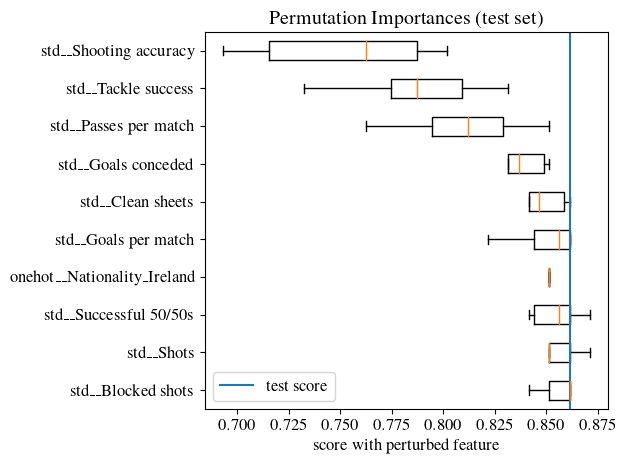

In [39]:
sorted_indcs = np.argsort(np.mean(scores,axis=1))[::-1][-10:]
# sorted_indcs=sorted_indcs[:10]
plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.figsize'] = [6,4]
plt.figure(figsize=(6.4,4.8))
print(feature_names[sorted_indcs])
plt.boxplot(scores[sorted_indcs].T,labels=feature_names[sorted_indcs],vert=False)
plt.axvline(test_score,label='test score')
plt.title("Permutation Importances (test set)")
plt.xlabel('score with perturbed feature')
plt.legend()
plt.tight_layout()
plt.savefig('/Users/kingsley/Desktop/DATA1030/Data_1030_Project/figures/permutation_importance.png', format='png', bbox_inches="tight", dpi=300)

plt.show()

In [34]:
#put all test scores in a list
model_names=np.array(['random forest', 'knn', 'svc', 'logistic regression','baseline'])
model_scores = np.zeros([5,5])
model_scores[0]=randomforest_test_scores
model_scores[1]=kneighborsclassifier_test_scores
model_scores[2]=svc_test_scores
model_scores[3]=logisticregression_test_scores
for i in range(5):
    model_scores[4][i]=randomforest_y_test[i].value_counts(1)[1]



model_scores

array([[0.89108911, 0.88118812, 0.85148515, 0.93069307, 0.91089109],
       [0.85148515, 0.86138614, 0.83168317, 0.87128713, 0.86138614],
       [0.85148515, 0.87128713, 0.83168317, 0.88118812, 0.85148515],
       [0.86138614, 0.86138614, 0.83168317, 0.89108911, 0.86138614],
       [0.37623762, 0.32673267, 0.37623762, 0.36633663, 0.40594059]])

In [35]:
model_scores[0].std()

0.02686071280445653

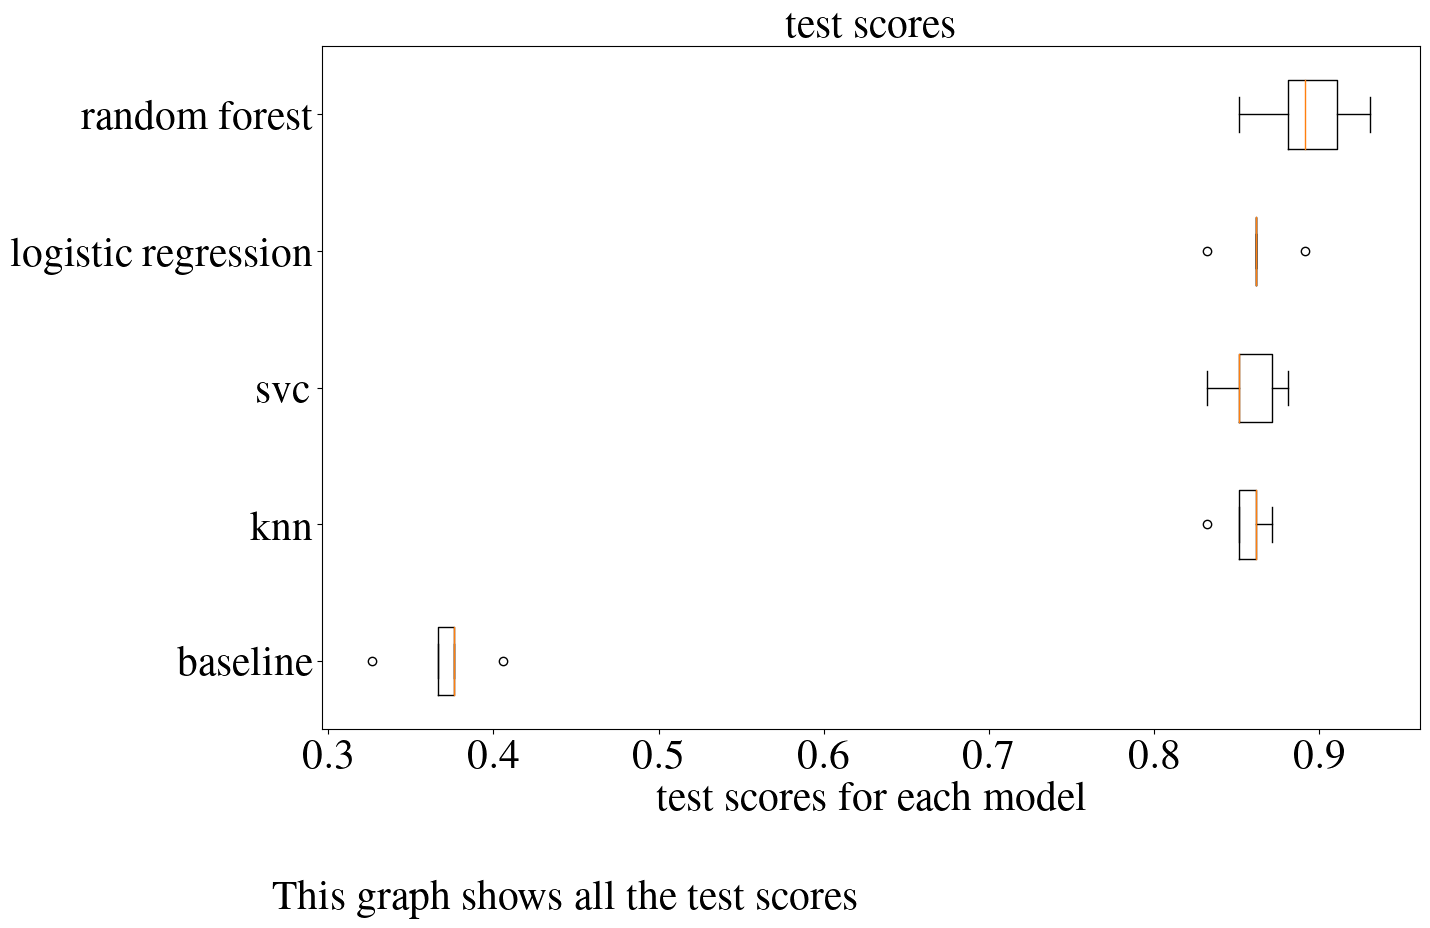

In [36]:
#plot the test scores
plt.rcParams['figure.figsize'] = [15,9]

sorted_indcs = np.argsort(np.mean(model_scores,axis=1))
plt.rcParams.update({'font.size': 30})
plt.boxplot(model_scores[sorted_indcs].T,labels=model_names[sorted_indcs],vert=False)
plt.title("test scores", size=30)
plt.xlabel('test scores for each model',size=30)
plt.tight_layout()
txt="This graph shows all the test scores"
plt.figtext(0.4, -0.05, txt, ha='center',size=30)
plt.savefig('/Users/kingsley/Desktop/DATA1030/Data_1030_Project/figures/test_score.png', format='png', bbox_inches="tight", dpi=300)

plt.show()

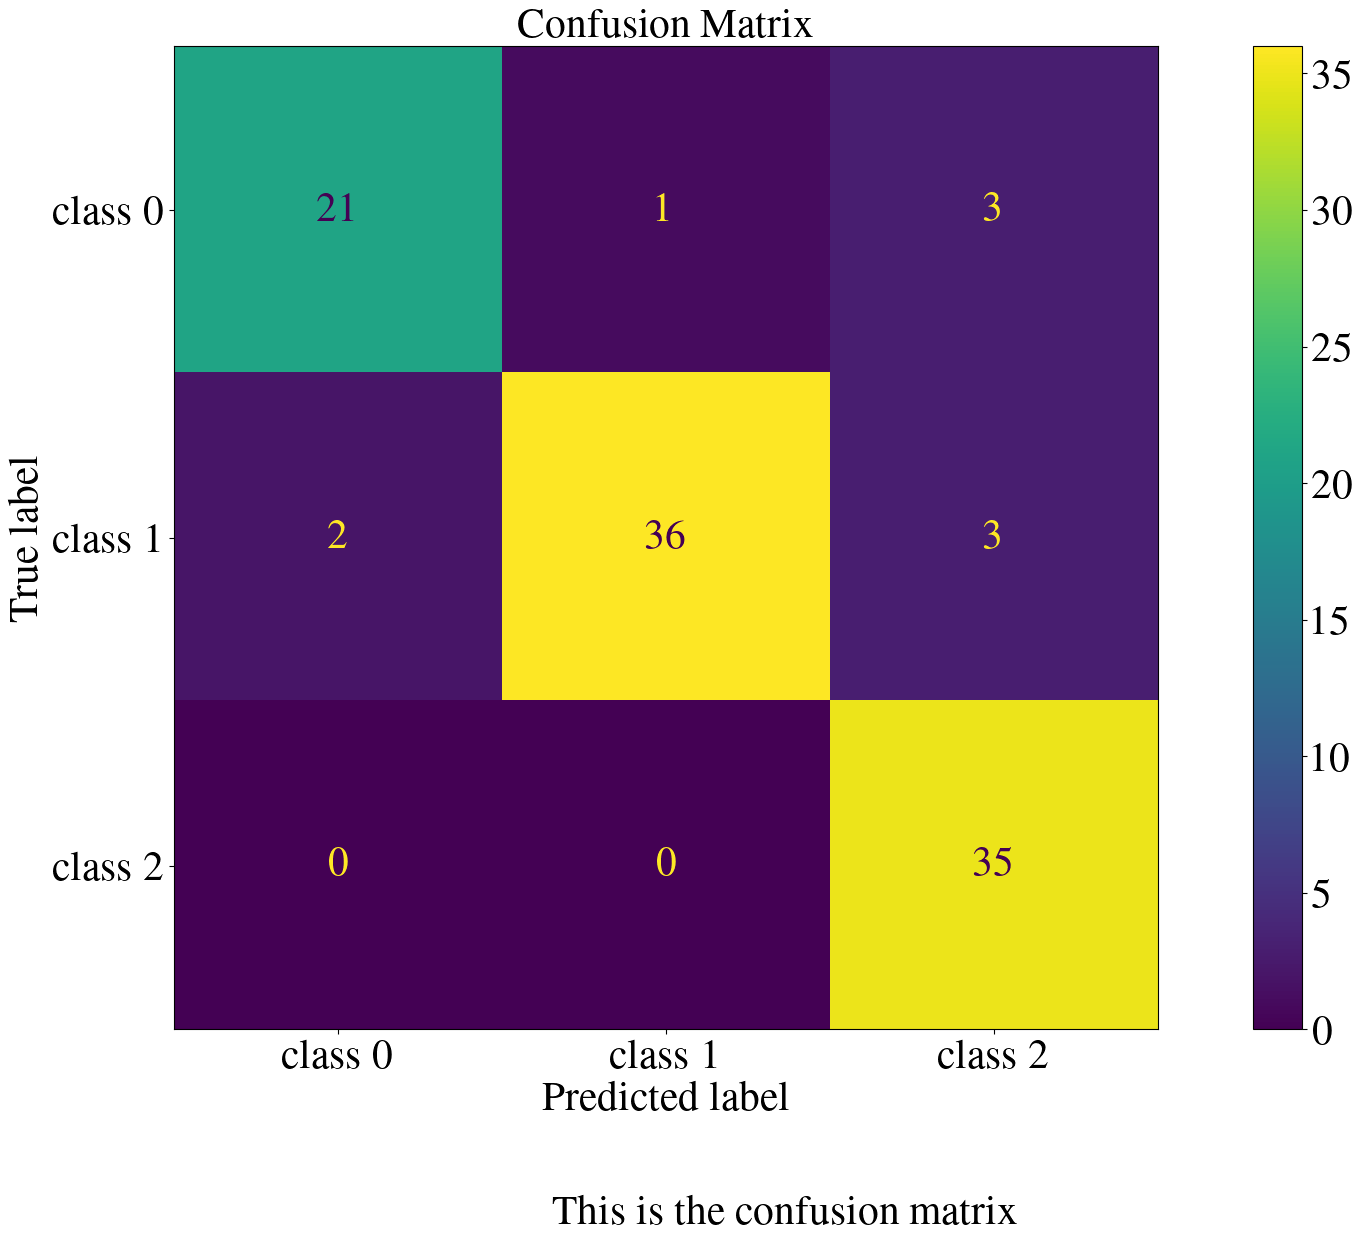

In [37]:
#plot confusion matrix
plt.rcParams.update({'font.size': 30})
plt.rcParams['figure.figsize'] = [20,12]


cm = confusion_matrix(randomforest_y_test[-1],randomforest_final_models[-1].predict(randomforest_X_test[-1]))
disp = ConfusionMatrixDisplay(cm,display_labels=['class 0', 'class 1', 'class 2'])
disp.plot()
plt.title("Confusion Matrix", size=30)
txt="This is the confusion matrix"
plt.figtext(0.6, -0.05, txt, ha='center',size=30)
plt.tight_layout()
plt.savefig('/Users/kingsley/Desktop/DATA1030/Data_1030_Project/figures/confusion_matrix.png', format='png', bbox_inches="tight", dpi=300)

plt.show()



In [38]:
import pickle
for i in range(5):
    filename = 'final_model_'+str(i)
    pickle.dump(randomforest_final_models[i],open(filename,'wb'))